# Check if discretizing the MD-Trajectory works

In [9]:
from MDAnalysis.lib.formats.libdcd import DCDFile
import numpy as np

traj = []
with DCDFile("../tests/Trajectories/HIVProtease/0-4_conc_wow.dcd") as f:
    for frame in f:
        traj.append(frame.xyz)
print(len(traj))

5006


In [11]:
traj = np.array(traj)
traj_l = traj[:, 3121:, :]
traj_l.shape

(5006, 79, 3)

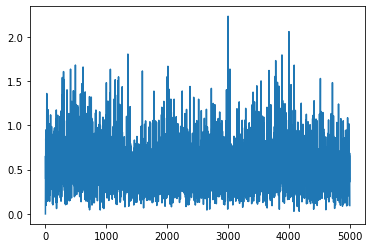

In [25]:
import matplotlib.pyplot as plt

diff = np.diff(traj_l, axis=0)
diff = np.sum(diff, axis=1) / diff.shape[1]
norm = np.linalg.norm(diff, axis=1)
plt.plot(norm)

In [32]:
diff.shape

(5005, 3)

In [48]:
import torch
from torch.utils.data import DataLoader
from deeptime.util.data import TrajectoryDataset

dataset = TrajectoryDataset(1, traj_l.astype(np.float32))

n_val = int(len(dataset) * 0.5)
train_data, val_data = torch.utils.data.random_split(
    dataset, [len(dataset) - n_val, n_val]
)
print(len(val_data))
loader_train = DataLoader(train_data, batch_size=64, shuffle=False)
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)

2502


In [49]:
import torch
from deeptime.util.torch import MLP

units = [3, 50, 50, 1]
encoder = MLP(
    units,
    nonlinearity=torch.nn.ReLU,
    output_nonlinearity=torch.nn.Sigmoid,
    initial_batchnorm=False,
)
decoder = MLP(units[::-1], nonlinearity=torch.nn.ReLU, initial_batchnorm=False)

In [50]:
from deeptime.decomposition.deep import TAE

tae = TAE(encoder, decoder, learning_rate=1e-3)
tae.fit(loader_train, n_epochs=30, validation_loader=loader_val)
tae_model = tae.fetch_model()

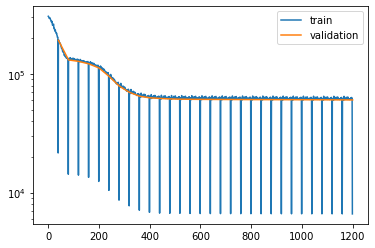

In [51]:
plt.semilogy(*tae.train_losses.T, label="train")
plt.semilogy(*tae.validation_losses.T, label="validation")
plt.legend();

In [52]:
proj = tae_model.transform(traj)
proj.shape

(5006, 3200, 1)

In [63]:
from sklearn.cluster import KMeans
from tqdm import tqdm

random_state = 42
scores = np.zeros(16)
sum_of_squared_distances = np.zeros(16)
for i in range(1, 16):
    clf = KMeans(n_clusters=i, random_state=random_state).fit(norm.reshape(-1, 1))
    scores[i] = clf.score(norm.reshape(-1, 1))
    sum_of_squared_distances[i] = clf.inertia_

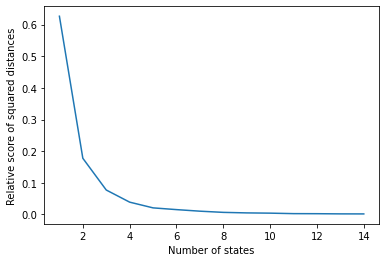

In [64]:
len(np.unique(proj))
metric = np.diff(sum_of_squared_distances[1:] / sum_of_squared_distances[1:][0])
diff = np.abs(np.diff(sum_of_squared_distances[1:] / sum_of_squared_distances[1:][0]))
plt.plot(np.arange(1, len(diff) + 1, 1), diff)
plt.xlabel("Number of states")
plt.ylabel("Relative score of squared distances")
plt.savefig("HIV_lignad_Traj_Ellbow.png", dpi=300)

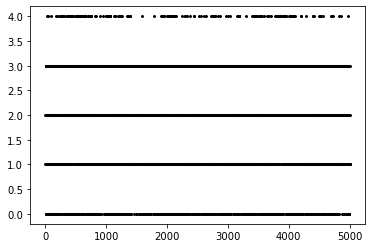

In [66]:
clf = KMeans(n_clusters=5, random_state=random_state).fit(norm.reshape(-1, 1))
labels = clf.labels_
plt.scatter(
    np.arange(0, len(norm.reshape(-1, 1)), 1), labels, marker="x", s=4, color="black"
)
plt.savefig("HIV_Discretized_Ligand_Traj.png", dpi=300)

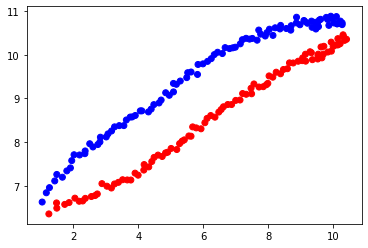

In [11]:
from MDAnalysis import Universe
import MDAnalysis.analysis.encore as encore
from MDAnalysis.tests.datafiles import PSF, DCD, DCD2
import matplotlib.pyplot as plt

ens1 = Universe(PSF, DCD)
ens2 = Universe(PSF, DCD2)
coordinates, details = encore.reduce_dimensionality([ens1, ens2])
plt.scatter(
    coordinates[0],
    coordinates[1],
    color=[["red", "blue"][m - 1] for m in details["ensemble_membership"]],
)

In [15]:
ens1 = Universe("../tests/Trajectories/ZIKV/trajectory.dcd")
coordinates, details = encore.reduce_dimensionality(ens1)

AttributeError: 'Topology' object has no attribute 'names'

In [5]:
from deeptime.data import sqrt_model

dtraj, traj = sqrt_model(n_samples=10000)

In [17]:
traj

array([[-5.18573987,  1.22733244],
       [-6.71045356,  1.5903144 ],
       [-3.28127219,  0.73881306],
       ...,
       [ 9.71996704,  4.20038916],
       [-5.71092724,  3.34319787],
       [ 6.03155811,  3.48683388]])

In [4]:
from torch.utils.data import DataLoader
from deeptime.util.data import TrajectoryDataset

dataset = TrajectoryDataset(1, traj.astype(np.float32))

n_val = int(len(dataset) * 0.5)
train_data, val_data = torch.utils.data.random_split(
    dataset, [len(dataset) - n_val, n_val]
)

loader_train = DataLoader(train_data, batch_size=64, shuffle=True)
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)

NameError: name 'traj' is not defined